In [1]:
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from models import MarkowitzMinVarianceModel, SharpeRatioMaxModel

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn') # style.use('ggplot') # style.use('fivethirtyeight')
%matplotlib inline

# pandas precision
pd.options.display.precision = 4

In [2]:
def get_df(symbol):
    df = pandas_datareader.data.DataReader(symbol, 'yahoo', st, ed) # daily
    df = df.sort_values(by='Date', ascending=True)
    df = df.resample('M').mean() # daily -> monthly
    df = df.fillna(method='ffill') # 1つ前の行の値で埋める
    df = df[['Close']].rename(columns={'Close': symbol})
    return df

# df: time-series price data of stocks in `symbols_tpx500`
st = datetime(2011, 10, 31)
ed = datetime(2020, 10, 31)
symbol='^N225'
df_n225 = get_df(symbol)

In [3]:
# TOPIX Index
df_tpx = pd.read_csv("../../data/tse_topix_20040331-20201031.csv")
df_tpx = df_tpx.set_index("Date")
df_tpx = df_tpx[df_tpx.index >= "2004-10-31"]

# TOPIX Core30 
df_tpx30 = pd.read_csv("../../data/tse_topixcore30_20001031-202010131.csv")
df_tpx30 = df_tpx30.set_index('Date')
df_tpx30 = df_tpx30[df_tpx30.index >= "2004-10-31"]

# TOPIX 500
df_tpx500 = pd.read_csv("../../data/tse_topix500_20001031-202010131.csv")
df_tpx500 = df_tpx500.set_index('Date')
df_tpx500 = df_tpx500[df_tpx500.index >= "2004-10-31"]

# Back-testing

In [4]:
# Investment period
ST_BACKTEST = datetime(2011,10,31)
ED_BACKTEST = datetime(2020,10,31)

# Risk-free rate (10Year-JGB, monthly interest)
jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond)
r_f = jgb_int * (1/12) # adjust monthly
r_e = r_f

# TOPIX Index
df_tpx = df_tpx.pct_change()
df_tpx[:1] = 0.0 # set 0.0 to the first record

#### TOPIX series

In [5]:
st = ST_BACKTEST.strftime('%Y-%m-%d') 
ed = ED_BACKTEST.strftime('%Y-%m-%d')

df0 = df_n225[st:ed]
df0["^TPX"] = df_tpx[st:ed].values
df0["TPXC30"] = df_tpx30[st:ed].mean(axis='columns').values
df0["TPX500"] = df_tpx500[st:ed].mean(axis='columns').values

df0 = df0.pct_change()
df0[:1] = 0.0

df0["Date"] = pd.to_datetime(df0.index)
df0 = df0.set_index("Date")
df0

<ipython-input-5-127574ecf380>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0["^TPX"] = df_tpx[st:ed].values
<ipython-input-5-127574ecf380>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0["TPXC30"] = df_tpx30[st:ed].mean(axis='columns').values
<ipython-input-5-127574ecf380>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,^N225,^TPX,TPXC30,TPX500
Date,,,,
2011-10-31,0.0000e+00,0.0000,0.0000,0.0000
2011-11-30,-5.3656e-02,4.8575,-0.0175,-0.0245
2011-12-31,-1.3296e-05,-1.1226,-0.0147,0.0016
2012-01-31,1.3016e-02,3.9035,0.0100,0.0126
2012-02-29,7.2605e-02,3.5551,0.0740,0.0513
...,...,...,...,...
2020-06-30,9.4614e-02,0.2246,0.0556,0.0630
2020-07-31,1.8918e-03,-1.2400,0.0006,-0.0190
2020-08-31,1.6510e-02,-2.3957,0.0393,0.0160


#### MarkowitzMinVarianceModel

In [23]:
for i, w in enumerate(range(3, 60+1)):
# for i, w in enumerate([3, 6, 12, 24, 36, 48, 60]):
    # Model Params
    params = {
        "window_size": w,
        "rebalance_freq": 1,
        "r_f": r_f
    }

    # Data
    st = (ST_BACKTEST - relativedelta(months=params["window_size"])).strftime('%Y-%m-%d')
    ed = ED_BACKTEST.strftime('%Y-%m-%d')
    df = df_tpx30[st:ed]
    df_re =  df_tpx[st:ed]
    params["r_e"] = df_re

    # Model (mmvp)
    model = MarkowitzMinVarianceModel(df, **params)
    df_bt = model.backtest()
    df_bt_r = model.get_dfbt_r()
    df_bt_x = model.get_dfbt_x()
    model.evaluate_backtest(logging=False)
    
    df_bt = df_bt[["ror"]]
    df_bt = df_bt.rename(columns={'ror': f'Mean-Variance Model (TOPIX Core30, {w} months)'})
    
    if i == 0:
        df1 = df_bt
    else:
        df1 = pd.concat([df1, df_bt], axis=1)

In [24]:
for i, w in enumerate(range(3, 60+1)):
# for i, w in enumerate([3, 6, 12, 24, 36, 48, 60, ]):

    # Model Params
    params = {
        "window_size": w,
        "rebalance_freq": 1,
        "r_f": r_f
    }

    # Data
    st = (ST_BACKTEST - relativedelta(months=params["window_size"])).strftime('%Y-%m-%d')
    ed = ED_BACKTEST.strftime('%Y-%m-%d')
    df = df_tpx30[st:ed]

    # Model (mmvp)
    model = SharpeRatioMaxModel(df, **params)
    df_bt = model.backtest()
    df_bt_r = model.get_dfbt_r()
    df_bt_x = model.get_dfbt_x()
    model.evaluate_backtest(logging=False)

    df_bt = df_bt[["ror"]]
    df_bt = df_bt.rename(columns={'ror': f'Sharpe-Ratio-Max Model (TOPIX Core30, {w} months)'})
    
    if i == 0:
        df2 = df_bt
    else:
        df2 = pd.concat([df2, df_bt], axis=1)

In [25]:
df = pd.concat([df0, df1, df2], axis=1)
df = df.rename(columns={'^N225': 'NIKKEI 225',
                        '^TPX': 'TOPIX Index',
                        'TPXC30': 'TOPIX Core30 (equal share)',
                        'TPX500': 'TOPIX 500 (equal share)'})
df_yearly = df.resample("y").sum()
df

,NIKKEI 225,TOPIX Index,TOPIX Core30 (equal share),TOPIX 500 (equal share),"Mean-Variance Model (TOPIX Core30, 3 months)","Mean-Variance Model (TOPIX Core30, 4 months)","Mean-Variance Model (TOPIX Core30, 5 months)","Mean-Variance Model (TOPIX Core30, 6 months)","Mean-Variance Model (TOPIX Core30, 7 months)","Mean-Variance Model (TOPIX Core30, 8 months)",...,"Sharpe-Ratio-Max Model (TOPIX Core30, 51 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 52 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 53 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 54 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 55 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)"
2011-10-31,0.0000e+00,0.0000,0.0000,0.0000,0.0000,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2011-11-30,-5.3656e-02,4.8575,-0.0175,-0.0245,0.0014,8.7360e-05,-4.3910e-05,-3.2515e-05,-5.0359e-05,-1.0255e-04,...,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389,-0.0389
2011-12-31,-1.3296e-05,-1.1226,-0.0147,0.0016,0.0278,-5.0017e-05,-1.1784e-04,-8.8192e-05,-9.6362e-05,-1.3728e-04,...,0.0495,0.0495,0.0495,0.0495,0.0495,0.0495,0.0495,0.0495,0.0495,0.0495
2012-01-31,1.3016e-02,3.9035,0.0100,0.0126,-0.0113,-3.2930e-02,-9.9274e-05,-5.7158e-05,-3.3931e-05,-3.9141e-05,...,-0.0829,-0.0829,-0.0829,-0.0829,-0.0829,-0.0829,-0.0829,-0.0829,-0.0829,-0.0813
2012-02-29,7.2605e-02,3.5551,0.0740,0.0513,0.0155,1.4048e-02,3.0418e-04,1.0478e-04,1.0262e-04,7.1635e-05,...,-0.0714,-0.0714,-0.0714,-0.0714,-0.0714,-0.0714,-0.0218,-0.0714,-0.0714,-0.0649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30,9.4614e-02,0.2246,0.0556,0.0630,-0.0344,-4.1865e-02,-4.5146e-02,-6.0148e-02,-6.0298e-02,-6.4215e-02,...,0.0098,-0.0011,-0.0092,-0.0156,-0.0077,0.0138,-0.0035,-0.0111,-0.0170,-0.0179
2020-07-31,1.8918e-03,-1.2400,0.0006,-0.0190,-0.0279,-2.8326e-02,-1.5845e-02,-2.4014e-02,-1.5019e-02,-2.8045e-02,...,0.0765,0.0641,0.0490,0.0363,0.0203,0.0276,0.0697,0.0478,0.0327,0.0230
2020-08-31,1.6510e-02,-2.3957,0.0393,0.0160,-0.0224,-6.3505e-03,-8.1150e-03,-1.0800e-02,-8.4732e-03,-1.1787e-02,...,0.0553,0.0587,0.0604,0.0486,0.0428,0.0382,0.0390,0.0530,0.0450,0.0379
2020-09-30,1.7706e-02,0.0753,0.0483,0.0310,0.0145,1.4362e-02,2.5621e-02,2.9159e-02,3.0009e-02,2.9297e-02,...,0.0575,0.0568,0.0563,0.0640,0.0632,0.0593,0.0518,0.0521,0.0658,0.0648


In [26]:
df.mean()

NIKKEI 225                                          0.0100
TOPIX Index                                         0.0081
TOPIX Core30 (equal share)                          0.0092
TOPIX 500 (equal share)                             0.0084
Mean-Variance Model (TOPIX Core30, 3 months)        0.0056
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.0118
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.0130
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.0120
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.0119
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.0100
Length: 120, dtype: float64

In [27]:
df.std(ddof=True)

NIKKEI 225                                          0.0471
TOPIX Index                                         4.7460
TOPIX Core30 (equal share)                          0.0449
TOPIX 500 (equal share)                             0.0424
Mean-Variance Model (TOPIX Core30, 3 months)        0.0544
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.0487
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.0496
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.0509
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.0509
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.0524
Length: 120, dtype: float64

In [83]:
s_yearly_ror = 12 * df.mean()
s_yearly_ror

NIKKEI 225                                          0.1195
TOPIX Index                                         0.0973
TOPIX Core30 (equal share)                          0.1099
TOPIX 500 (equal share)                             0.1010
Mean-Variance Model (TOPIX Core30, 3 months)        0.0672
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.1414
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.1564
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.1435
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.1424
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.1201
Length: 120, dtype: float64

In [84]:
s_yearly_sharperatio = (12 * df.mean() - 0.0001) / (np.sqrt(12) * df.std(ddof=True))
s_yearly_sharperatio

NIKKEI 225                                          0.7323
TOPIX Index                                         0.0059
TOPIX Core30 (equal share)                          0.7059
TOPIX 500 (equal share)                             0.6864
Mean-Variance Model (TOPIX Core30, 3 months)        0.3562
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.8371
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.9087
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.8127
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.8067
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.6604
Length: 120, dtype: float64

### 感度分析, Return

In [104]:
s_yearly_ror = 12 * df.mean()
s_yearly_ror

NIKKEI 225                                          0.1195
TOPIX Index                                         0.0973
TOPIX Core30 (equal share)                          0.1099
TOPIX 500 (equal share)                             0.1010
Mean-Variance Model (TOPIX Core30, 3 months)        0.0672
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.1414
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.1564
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.1435
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.1424
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.1201
Length: 120, dtype: float64

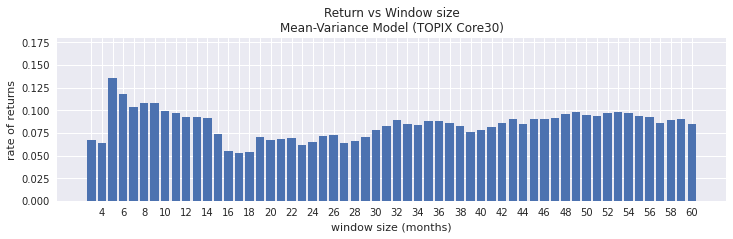

In [96]:
s = s_yearly_ror[s_yearly_ror.index.str.contains('Mean-Variance')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)


plt.title("Return vs Window size\nMean-Variance Model (TOPIX Core30)")
plt.ylabel("rate of returns")
plt.xlabel("window size (months)")
plt.ylim([0,0.18])
plt.show()

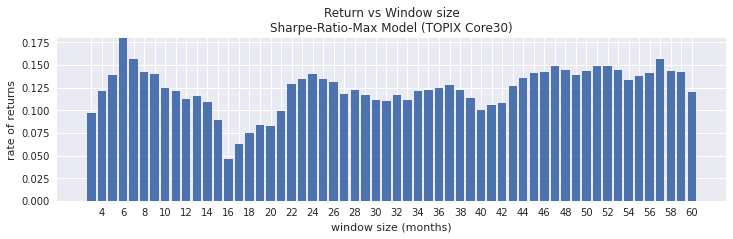

In [100]:
s = s_yearly_ror[s_yearly_ror.index.str.contains('Sharpe')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)

plt.title("Return vs Window size\nSharpe-Ratio-Max Model (TOPIX Core30)")
plt.ylabel("rate of returns")
plt.xlabel("window size (months)")
plt.ylim([0,0.18])
plt.show()

### 感度分析, Risk

In [105]:
s_yearly_std = np.sqrt(12) * df.std(ddof=True)
s_yearly_std

NIKKEI 225                                           0.1630
TOPIX Index                                         16.4406
TOPIX Core30 (equal share)                           0.1556
TOPIX 500 (equal share)                              0.1470
Mean-Variance Model (TOPIX Core30, 3 months)         0.1883
                                                     ...   
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)     0.1688
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)     0.1720
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)     0.1764
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)     0.1764
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)     0.1817
Length: 120, dtype: float64

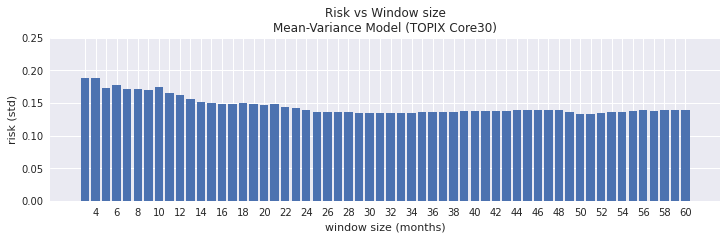

In [113]:
s = s_yearly_std[s_yearly_std.index.str.contains('Mean-Variance')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)


plt.title("Risk vs Window size\nMean-Variance Model (TOPIX Core30)")
plt.ylabel("risk (std)")
plt.xlabel("window size (months)")
plt.ylim([0,0.25])
plt.show()

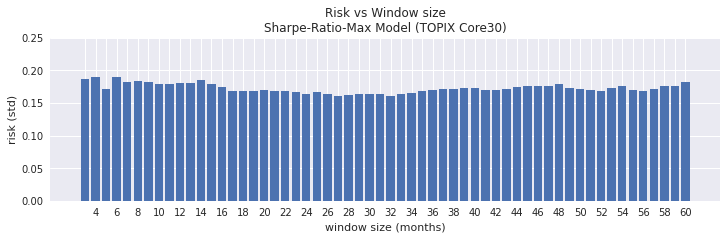

In [112]:
s = s_yearly_std[s_yearly_std.index.str.contains('Sharpe-Ratio-Max')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)


plt.title("Risk vs Window size\nSharpe-Ratio-Max Model (TOPIX Core30)")
plt.ylabel("risk (std)")
plt.xlabel("window size (months)")
plt.ylim([0,0.25])
plt.show()

### 感度分析, SR

In [103]:
s_yearly_sharperatio = (12 * df.mean() - 0.0001) / (np.sqrt(12) * df.std(ddof=True))
s_yearly_sharperatio

NIKKEI 225                                          0.7323
TOPIX Index                                         0.0059
TOPIX Core30 (equal share)                          0.7059
TOPIX 500 (equal share)                             0.6864
Mean-Variance Model (TOPIX Core30, 3 months)        0.3562
                                                     ...  
Sharpe-Ratio-Max Model (TOPIX Core30, 56 months)    0.8371
Sharpe-Ratio-Max Model (TOPIX Core30, 57 months)    0.9087
Sharpe-Ratio-Max Model (TOPIX Core30, 58 months)    0.8127
Sharpe-Ratio-Max Model (TOPIX Core30, 59 months)    0.8067
Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)    0.6604
Length: 120, dtype: float64

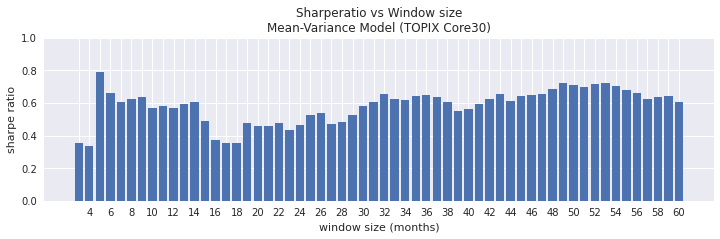

In [98]:
s = s_yearly_sharperatio[s_yearly_sharperatio.index.str.contains('Mean')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)

plt.title("Sharperatio vs Window size\nMean-Variance Model (TOPIX Core30)")
plt.ylabel("sharpe ratio")
plt.xlabel("window size (months)")
plt.ylim([0,1])
plt.show()

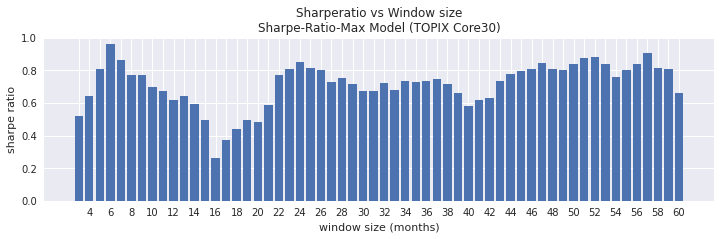

In [101]:
s = s_yearly_sharperatio[s_yearly_sharperatio.index.str.contains('Sharpe-Ratio-Max')]
x = [s for s in range(3, 61)]
y = s.values

fig, ax = plt.subplots(figsize=(12,3))

xlabels = x
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels)
ax.bar(x,y)

# 変更部分
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 == 0:
        label.set_visible(False)

plt.title("Sharperatio vs Window size\nSharpe-Ratio-Max Model (TOPIX Core30)")
plt.ylabel("sharpe ratio")
plt.xlabel("window size (months)")
plt.ylim([0,1])
plt.show()

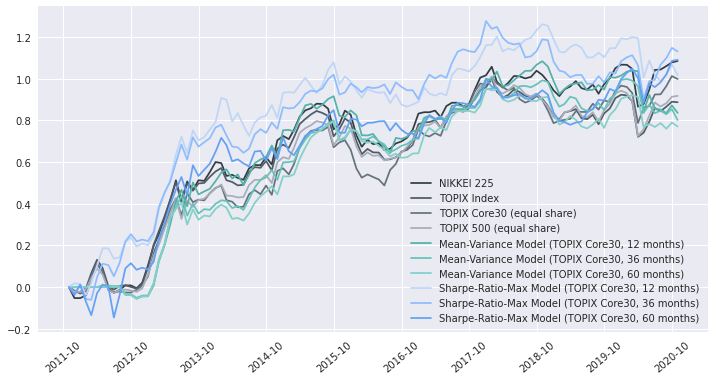

In [75]:
fig, ax = plt.subplots(figsize=(12,6))
xlabels = [d.strftime('%Y-%m') for idx, d in enumerate(df.index) if idx % 12 == 0]
colors = ['#343d46','#4f5b66','#65737e','#a7adba', 
          '#54b2a9','#65c3ba','#83d0c9',
          '#bfd6f6','#8dbdff','#64a1f4']

for i, col in enumerate(df.columns):
    ax.plot(df.index.values, df[str(col)].cumsum().values, label=f"{col}", color=colors[i])
ax.legend(loc="lower right")
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, rotation=40)
# plt.show()
# plt.savefig("../../figures/portfolio_plot_comparison.png", bbox_inches="tight")

In [78]:
df

,NIKKEI 225,TOPIX Index,TOPIX Core30 (equal share),TOPIX 500 (equal share),"Mean-Variance Model (TOPIX Core30, 12 months)","Mean-Variance Model (TOPIX Core30, 36 months)","Mean-Variance Model (TOPIX Core30, 60 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 12 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 36 months)","Sharpe-Ratio-Max Model (TOPIX Core30, 60 months)"
2011-10-31,0.0000e+00,0.0000,0.0000,0.0000,0.0000e+00,0.0000e+00,0.0000e+00,0.0000,0.0000,0.0000
2011-11-30,-5.3656e-02,-0.0269,-0.0175,-0.0245,-6.2980e-05,-7.8267e-05,-7.7203e-05,0.0174,-0.0311,-0.0389
2011-12-31,-1.3296e-05,0.0033,-0.0147,0.0016,-5.3176e-05,-5.9641e-05,-4.4003e-05,-0.0033,0.0407,0.0495
2012-01-31,1.3016e-02,0.0162,0.0100,0.0126,-6.5761e-05,-2.4643e-05,-3.8446e-05,-0.0528,-0.0676,-0.0813
2012-02-29,7.2605e-02,0.0738,0.0740,0.0513,4.6728e-05,3.6677e-05,4.9937e-05,0.0604,-0.0043,-0.0649
...,...,...,...,...,...,...,...,...,...,...
2020-06-30,9.4614e-02,0.0656,0.0556,0.0630,-6.6437e-02,-4.1337e-02,-1.4642e-02,-0.0674,0.0062,-0.0179
2020-07-31,1.8918e-03,-0.0158,0.0006,-0.0190,-4.6355e-03,1.1601e-02,1.8466e-02,-0.0317,0.0725,0.0230
2020-08-31,1.6510e-02,0.0220,0.0393,0.0160,-1.6615e-02,-1.7123e-02,-2.7132e-02,0.0288,0.0315,0.0379
2020-09-30,1.7706e-02,0.0236,0.0483,0.0310,3.6943e-02,2.5022e-02,2.9833e-02,0.0510,0.0490,0.0648


In [87]:
df_yearly = df.resample("y").sum()

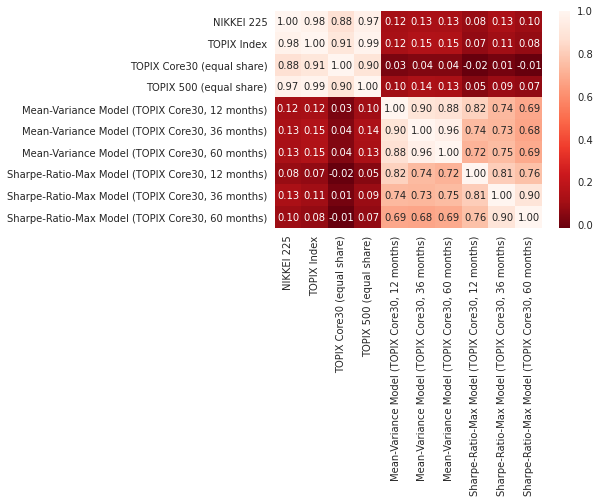

In [110]:
sns.heatmap(df.corr(), fmt=".2f", annot=True, cbar=True, cmap="Reds_r")
plt.savefig("../../figures/portfolio_comparison_corrcoef_monthly.png", bbox_inches="tight")

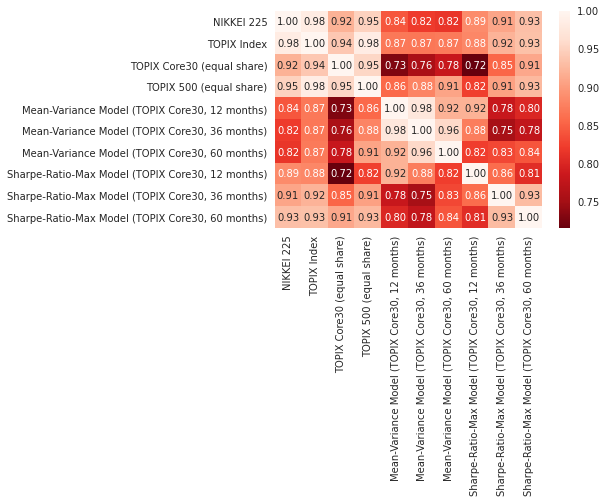

In [109]:
sns.heatmap(df_yearly.corr(), fmt=".2f", annot=True, cbar=True, cmap="Reds_r")
plt.savefig("../../figures/portfolio_comparison_corrcoef_yearly.png", bbox_inches="tight")